In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [1]:
import pennylane as qml
import numpy as np
import torch as torch
import qutip as qt
from matplotlib import pyplot as plt
import optim
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

We also declare a 3-qubit simulator device running in Cirq.


In [2]:
dev = qml.device('cirq.simulator', wires=3)

Generator and Discriminator
===========================




In [3]:
def U1(w,wire):
    qml.RZ(w[0],wires = wire)
    qml.RX(w[1],wires = wire)
    qml.RZ(w[2],wires = wire)

def U2(w,wire1,wire2):
    U1(w[0:3], wire1)
    U1(w[3:6], wire2)
    qml.CNOT(wires = [wire2,wire1])
    qml.RZ(w[6],wires = wire1)
    qml.RY(w[7],wires = wire2)
    qml.CNOT(wires = [wire1,wire2])
    qml.RY(w[8],wires = wire2)
    qml.CNOT(wires = [wire2,wire1])
    U1(w[9:12], wire1)
    U1(w[12:15],wire2)

In [4]:
def real(w, **kwargs):
    U2(w,0,1)
    

def generator(w, **kwargs):
    U2(w[0:15],0,1)
    #U2(w[15:30],0,1) Erase this, be careful with overparametrization
    
def discriminator(w, **kwargs):
    U2(w[0:15],0,1)
    U2(w[15:30],1,2)
    U2(w[30:45],0,1)
    U2(w[45:60],1,2)

# Nodes

In [5]:
@qml.qnode(dev, interface="torch")
def real_disc_circuit(real_params, disc_weights):
    real(real_params)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))


@qml.qnode(dev, interface="torch")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

QGAN cost functions
===================




In [6]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(real_params, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights, gen_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights, disc_weights):
    cost = -prob_fake_true(gen_weights, disc_weights)
    return cost

Initializing the weights
=================


Real state generation

In [7]:
real_params = np.random.uniform(low=-np.pi, high=np.pi, size=15)

Generator and Discriminator parameter initialization

In [8]:
init_gen_weights = np.random.uniform(low=-np.pi, high=np.pi, size=15)

init_disc_weights = np.random.uniform(low=-np.pi, high=np.pi, size=60)

gen_weights_grad = torch.tensor(init_gen_weights, requires_grad=True)
disc_weights_grad = torch.tensor(init_disc_weights, requires_grad=True)

We train in turns. We expect around 250 turns to converge. Each turn consists of 20 discriminator steps and 1 generator step.

# Define some other metrics

In [9]:
dev_state = qml.device('default.qubit', wires=2)

In [10]:
@qml.qnode(dev_state, interface="torch")
def real_circuit(w):
    U1(w[0:3], 0)
    U1(w[3:6], 1)
    qml.CNOT(wires = [1,0])
    qml.RZ(w[6],wires = 0)
    qml.RY(w[7],wires = 1)
    qml.CNOT(wires = [0,1])
    qml.RY(w[8],wires = 1)
    qml.CNOT(wires = [1,0])
    U1(w[9:12], 0)
    U1(w[12:15],1)
    return qml.state()


@qml.qnode(dev_state, interface="torch")
def gen_circuit(gen_weights):
    generator(gen_weights)
    return qml.state()

In [11]:
def fidelity(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).detach().numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).detach().numpy())
    
    ρ_R = real_state * real_state.dag()
    ρ_G = gen_state * gen_state.dag()
    
    F = qt.fidelity(ρ_R,ρ_G)
    return F

In [12]:

def trace_distance(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).detach().numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).detach().numpy())
    
    ρ_R = real_state * real_state.dag()
    ρ_G = gen_state * gen_state.dag()
    
    d = qt.tracedist(ρ_R,ρ_G)
    return d

------------------------------------------------------------------------------

# Training routine

In [13]:
#----- Metrics ----------------------------

Disc_cost = [] # P(R|R)-P(R|G)
Gen_cost = [] # P(R|G)
Trace_d = [] #Trace distance
F = [] #Fidelity

#-------------------------------------------


for turn in range(30):
    
     #training discriminator
    #OAdam only updates the parameters with requires_grad = True and doesn't change the other ones
    gen_weights_non_grad = torch.tensor(gen_weights_grad.detach().numpy(), requires_grad = False)
    #need an optimizer for both cases seperately
    opt = optim.OAdam([disc_weights_grad, gen_weights_non_grad], lr = 0.1)
    
    def closure():
        opt.zero_grad()
        loss = disc_cost(disc_weights_grad, gen_weights_non_grad)
        loss.backward()
        return loss
    
    for step in range(20): #The actual ratio should be 20 to 1, according to what we discussed
        opt.step(closure)
        if step == 19:
            costD_val = disc_cost(disc_weights_grad, gen_weights_non_grad).detach().numpy()
            #print("Step {}: cost = {}".format(step, costD_val))
            Disc_cost += [-costD_val] # P(R|R)-P(R|G)
            
    del opt
      
    #training generator
    #switch requires_grad for both weight sets
    disc_weights_non_grad = torch.tensor(disc_weights_grad.detach().numpy(), requires_grad = False)
    gen_weights_grad = torch.tensor(gen_weights_non_grad.detach().numpy(), requires_grad = True)
    #define new optimizer
    opt = optim.OAdam([disc_weights_non_grad, gen_weights_grad], lr = 0.1)
    
    def closure():
        opt.zero_grad()
        loss = gen_cost(gen_weights_grad, disc_weights_non_grad)
        loss.backward()
        return loss
    
    opt.step(closure)
    costG_val = gen_cost(gen_weights_grad, disc_weights_grad).detach().numpy()
    #print("Step {}: cost = {}".format(step, costG_val))
    Gen_cost += [-costG_val] # P(R|G)
    
    fid = fidelity(real_params,gen_weights_grad)
    F += [fid] #Fidelity
    
    TrD = trace_distance(real_params,gen_weights_grad)
    Trace_d += [TrD] #Trace distance
    
    print("P(R|R)-P(R|G): ", -costD_val)
    print("P(R|G): ", -costG_val)
    print("Fidelity: ",fid)
    print("Trace distance: ",TrD)
    print("------------------------------")
    
     #switch discriminator weights back to requires_grad
    disc_weights_grad = torch.tensor(disc_weights_non_grad.detach().numpy(), requires_grad = True)
    del opt

C:\Users\sarah\Downloads\qGANs-main\qGANs-main\optim.py:95: UserWarning: This overload of addcdiv_ is deprecated:
	addcdiv_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcdiv_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  p.data.addcdiv_(step_size, exp_avg, exp_avg_sq.sqrt().add(group['eps']))


P(R|R)-P(R|G):  0.8370315432548523
P(R|G):  0.3958519250154495
Fidelity:  0.7651789695609539
Trace distance:  0.6438176419868399
------------------------------
P(R|R)-P(R|G):  0.6417476087808609
P(R|G):  0.4128824770450592
Fidelity:  0.8869200951877142
Trace distance:  0.46192289093096917
------------------------------
P(R|R)-P(R|G):  0.4603835642337799
P(R|G):  0.4887005090713501
Fidelity:  0.9137742077821919
Trace distance:  0.406222488838036
------------------------------
P(R|R)-P(R|G):  0.4058632105588913
P(R|G):  0.5302238613367081
Fidelity:  0.9427010431619663
Trace distance:  0.33363865726224806
------------------------------
P(R|R)-P(R|G):  0.33348478376865387
P(R|G):  0.739726260304451
Fidelity:  0.9647053273528476
Trace distance:  0.26333179265079987
------------------------------
P(R|R)-P(R|G):  0.2629607766866684
P(R|G):  0.8170832395553589
Fidelity:  0.9394034411418988
Trace distance:  0.3428136362477484
------------------------------
P(R|R)-P(R|G):  0.3420441150665283
P(R

In [14]:
F = np.array(F)
Gen_cost = np.array(Gen_cost)
Disc_cost = np.array(Disc_cost)
Trace_d = np.array(Trace_d)

In [15]:
print(max(F))
print(F[-1])

0.9647083916227623
0.939404727962828


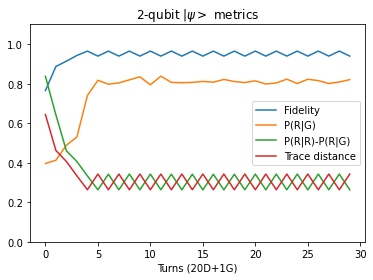

In [16]:
plt.plot(F, label='Fidelity')
plt.plot(Gen_cost, label='P(R|G)')
plt.plot(Disc_cost, label='P(R|R)-P(R|G)')
plt.plot(Trace_d, label='Trace distance')
plt.ylim([0,1.1])
plt.xlabel('Turns (20D+1G)') 
plt.title("2-qubit $|\psi>$ metrics")
plt.legend()
plt.savefig('2qubitlearning.png', format='png')

In [17]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_city

C:\Users\sarah\anaconda3\lib\site-packages\qiskit\visualization\bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


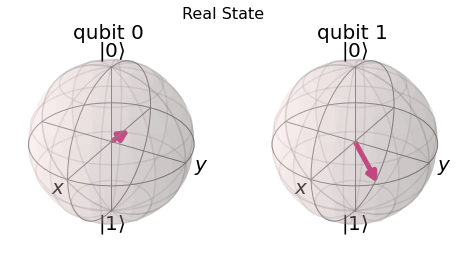

In [18]:
real_state = qt.Qobj(real_circuit(real_params).detach().numpy()).full() 
plot_bloch_multivector(Statevector(real_state), title="Real State", reverse_bits=False)


C:\Users\sarah\anaconda3\lib\site-packages\qiskit\visualization\bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


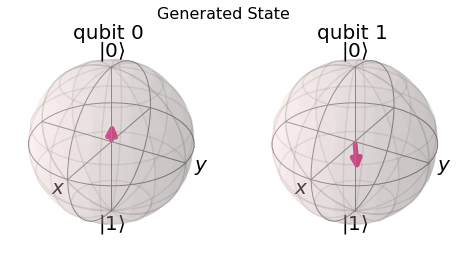

In [19]:
gen_state = qt.Qobj(gen_circuit(gen_weights_grad).detach().numpy()).full()
plot_bloch_multivector(Statevector(gen_state), title="Generated State", reverse_bits=False)



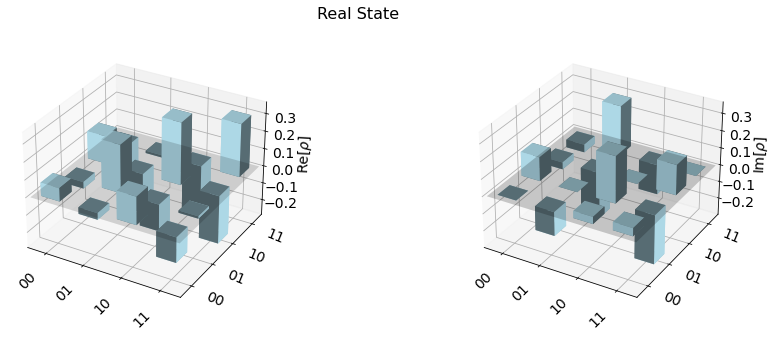

In [20]:
plot_state_city(Statevector(real_state), color=['lightblue', 'lightblue'],
     title="Real State")

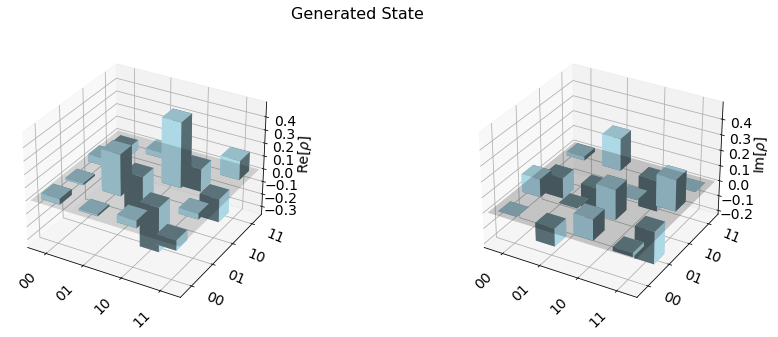

In [21]:
plot_state_city(Statevector(gen_state), color=['lightblue', 'lightblue'],
     title="Generated State")

In [23]:
print(real_state)
print(gen_state)

[[-0.13380803+0.23933495j]
 [-0.37307945-0.36467455j]
 [-0.15078569+0.57341974j]
 [ 0.4012092 -0.37433014j]]
[[-0.02116669-0.20616337j]
 [ 0.54875945-0.12012656j]
 [-0.67317078-0.20432252j]
 [ 0.15583402+0.34970055j]]
